<a href="https://colab.research.google.com/github/prethasur/ml-fraud-detection/blob/main/fraud_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from time import time
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
df_raw=pd.read_csv('/content/drive/MyDrive/datascience projects/test-assignments/pred-fraud-transaction/Fraud.csv')

#EDA

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_raw.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df_raw.isFraud.value_counts() # that's just 0.129% of the whole set = fraud

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
df_raw.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


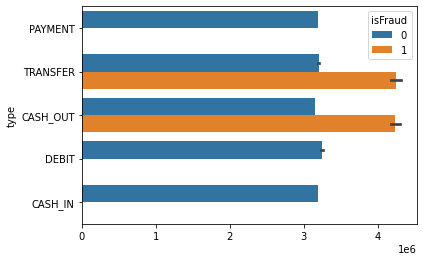

In [ ]:
sns.barplot(df_raw.index,df_raw.type, hue=df_raw['isFraud'])

In [ ]:
df_raw.nameOrig.str.startswith('C').sum() #all are customer ids only, we'll drop them

6362620

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


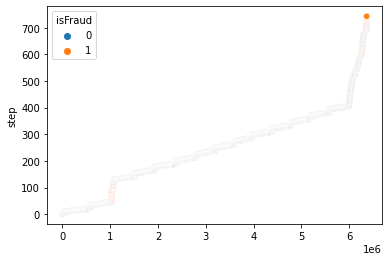

In [ ]:
sns.scatterplot(df_raw.index, df_raw.step, hue=df_raw.isFraud) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


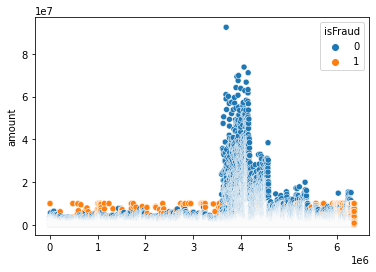

In [ ]:
sns.scatterplot(df_raw.index, df_raw.amount, hue=df_raw.isFraud) # fraud transactions mainly in less amounts

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


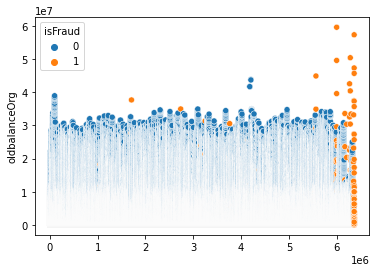

In [ ]:
sns.scatterplot(df_raw.index, df_raw.oldbalanceOrg, hue=df_raw.isFraud) 

In [ ]:
np.corrcoef(df_raw.isFraud, df_raw.isFlaggedFraud) #real fraud is very less correlated with flag

array([[1.       , 0.0441092],
       [0.0441092, 1.       ]])

In [ ]:
np.corrcoef(df_raw.amount, df_raw.isFlaggedFraud) #amt is very less correlated with flag

array([[1.       , 0.0122946],
       [0.0122946, 1.       ]])

In [ ]:
df_raw['rType'] = df_raw['nameDest'].astype(str).str[0]
df_raw['rType'].value_counts()

C    4211125
M    2151495
Name: rType, dtype: int64

In [ ]:
#ramdom subsample to see distribution
import random
p = 0.01  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         '/content/drive/MyDrive/datascience projects/test-assignments/pred-fraud-transaction/Fraud.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

In [ ]:
df_raw.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

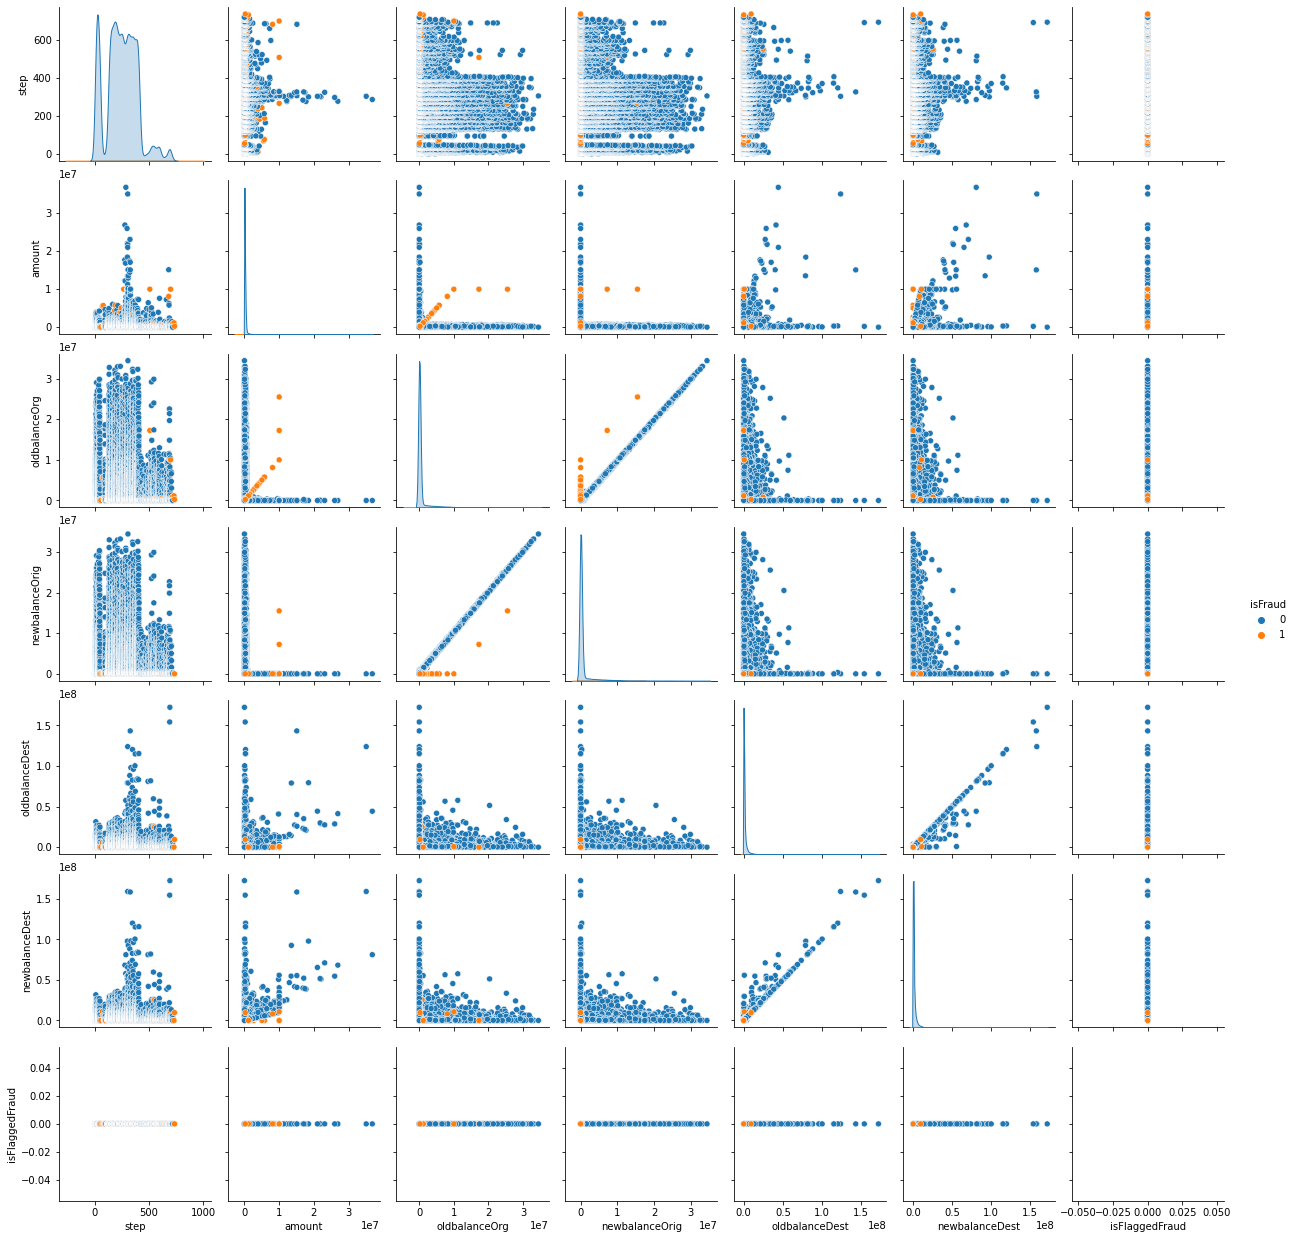

In [ ]:
sns.pairplot(df,hue='isFraud')

#Cleaning

In [ ]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,rType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,M
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,M
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,C
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,C
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,M


In [ ]:
''' 
droping name as it does not contribute to the problem, 
amount can be infered from the original and new balance, we could remove original balance, but it tells about the target accounts, new balance is often 0 in case of frauds- thats an indicator.
the type of reciepient is already reflected in balanceDest
'''
df_clean=df_raw.drop(['nameOrig','amount','nameDest','rType','isFlaggedFraud'],axis=1)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df_raw['type'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

print(lb_results_df.head())

   CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER
0        0         0      0        1         0
1        0         0      0        1         0
2        0         0      0        0         1
3        0         1      0        0         0
4        0         0      0        1         0


In [ ]:
df_clean=pd.concat([lb_results_df, df_clean], axis=1)
df_clean=df_clean.drop('type', axis=1)
df_clean.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,0,0,1,0,1,170136.0,160296.36,0.0,0.0,0
1,0,0,0,1,0,1,21249.0,19384.72,0.0,0.0,0
2,0,0,0,0,1,1,181.0,0.00,0.0,0.0,1
3,0,1,0,0,0,1,181.0,0.00,21182.0,0.0,1
4,0,0,0,1,0,1,41554.0,29885.86,0.0,0.0,0


#prep

In [ ]:
X=df_clean.drop('isFraud', axis=1)
y=df_clean.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
y_train.value_counts()

isFraud
0          4448056
1             5778
dtype: int64

In [ ]:
y_test.value_counts()

isFraud
0          1906351
1             2435
dtype: int64

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [ ]:
y_res.value_counts()

isFraud
0          4448056
1          4448056
dtype: int64

In [ ]:
scaler = StandardScaler()
X_train_use = scaler.fit_transform(X_res)

#train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100)
classifier_rf.fit(X_train_use, y_res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [ ]:
y_pred=classifier_rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print("RF Accuracy:", accuracy_score(y_test, y_pred))

RF Accuracy: 0.9987243200652143


In [ ]:
print('RF Precision: %.3f' % precision_score(y_test, y_pred))
print('RF Recall: %.3f' % recall_score(y_test, y_pred))
print('RF F1 Score: %.3f' % f1_score(y_test, y_pred))
print('confusion matrix \n', confusion_matrix(y_test,y_pred)) 
print('cohens kappa \n', cohen_kappa_score(y_test,y_pred))
print('ROC_AUC score \n', roc_auc_score(y_test,y_pred))

In [ ]:
pd.DataFrame(y_pred).value_counts()

0    1908786
dtype: int64

# hyper-parameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=29, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}


In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_train_use, y_res)

In [ ]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

# Viz

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['not fraud', "fraud"],filled=True);

In [ ]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)
print(imp_df)

# end